# セミパラメトリック回帰モデル(Cox比例ハザード回帰モデル)
> 確率分布の仮定をせず、生存時間が説明変数に依存すると想定したモデル

Cox比例ハザードモデルの各式

**<font color="blue">ハザード関数</font>**:
$$
h\left(t, x, \beta\right) = h_{0}\left(t\right)e^{x\beta} = h_{0}\left(t\right)exp\left\{ \sum {x_{i}\beta_{i}} \right\}
$$

**<font color="blue">生存関数</font>**:
$$
S\left( t,x,\beta \right) = \left[ S_{0}\left(t\right) \right]^{exp\left( x\beta \right)}
$$

**<font color="blue">累積ハザード関数</font>**:
$$
H\left( t,x,\beta \right) = \int _{0}^{t}{h\left( u,x,\beta \right)du} \quad \mathrm{(上式のハザード関数より)}\\
= e^{x\beta}\int _{0}^{t}{h_{0}\left( h \right)du}\\
= e^{x\beta}H_{0}\left( t \right)
$$


## 使用したパッケージ

 - [Survival analysis built on top of scikit-learn](https://github.com/sebp/scikit-survival)

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントを設定
font = {'family': 'IPAexGothic'}
mpl.rc('font', **font)

%matplotlib inline

In [3]:
WHAS_SURVIVAL_DATASET_PATH = 'dataset/actg320.dat'
COLUMNS = ['time', 'censor', 'time_d', 'censor_d', 'tx', 'txgrp', 'start2', 'sex', 'raceth', 'ivdrug', 'hemophil', 'karnof', 'cd4', 'priorzdv', 'age']

whas_df = pd.read_csv(WHAS_SURVIVAL_DATASET_PATH, sep='\s+', header=None, index_col=0, names=COLUMNS)
whas_df.head()

,time,censor,time_d,censor_d,tx,txgrp,start2,sex,raceth,ivdrug,hemophil,karnof,cd4,priorzdv,age
1,189,0,189,0,0,1,1,1,1,1,0,100,169.0,39.0,34
2,287,0,287,0,0,1,1,2,2,1,0,90,149.5,15.0,34
3,242,0,242,0,1,2,0,1,1,1,1,100,23.5,9.0,20
4,199,0,199,0,0,1,1,1,1,1,0,90,46.0,53.0,48
5,286,0,286,0,1,2,0,1,1,3,0,90,10.0,12.0,46


actg320は、HIV感染者を対象に、インジナビル(IDV), 非盲検のジドブジン(ZDV)またはスタブジン(d4T),ラミブジン(3TC)の3剤併用療法とZDVまたはd4T,3TCの2剤併用療法を比較するために実施された臨床データである

In [4]:
from sksurv.datasets import load_veterans_lung_cancer

x, y = load_veterans_lung_cancer()
x.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,'squamous',60.0,7.0,'no','standard'
1,64.0,'squamous',70.0,5.0,'yes','standard'
2,38.0,'squamous',60.0,3.0,'no','standard'
3,63.0,'squamous',60.0,9.0,'yes','standard'
4,65.0,'squamous',70.0,11.0,'yes','standard'


 - `Age_in_years`: 年齢
 - `Celltype`: 細胞の種類; `[squamous(扁平上皮), small cell, adeno(腺癌), large]`
 - `Karnofsky_score`: カルノフスキースコア(がん患者の日常活動を遂行する能力を計るための標準的な値.0~100)
 - `Months_from_Diagnosis`: 診断からの経過月数
 - `Prior_therapy`: 前に治療したかいなか; `[yes, no]`
 - `Treatment`: 肺癌治療のタイプ; `[standard, test drug]`

In [6]:
y

array([( True,   72.), ( True,  411.), ( True,  228.), ( True,  126.),
       ( True,  118.), ( True,   10.), ( True,   82.), ( True,  110.),
       ( True,  314.), (False,  100.), ( True,   42.), ( True,    8.),
       ( True,  144.), (False,   25.), ( True,   11.), ( True,   30.),
       ( True,  384.), ( True,    4.), ( True,   54.), ( True,   13.),
       (False,  123.), (False,   97.), ( True,  153.), ( True,   59.),
       ( True,  117.), ( True,   16.), ( True,  151.), ( True,   22.),
       ( True,   56.), ( True,   21.), ( True,   18.), ( True,  139.),
       ( True,   20.), ( True,   31.), ( True,   52.), ( True,  287.),
       ( True,   18.), ( True,   51.), ( True,  122.), ( True,   27.),
       ( True,   54.), ( True,    7.), ( True,   63.), ( True,  392.),
       ( True,   10.), ( True,    8.), ( True,   92.), ( True,   35.),
       ( True,  117.), ( True,  132.), ( True,   12.), ( True,  162.),
       ( True,    3.), ( True,   95.), ( True,  177.), ( True,  162.),
      

観測期間中に死亡した場合は`Status`が`True`になり、`False`の場合は右側打切りである。

---
# 単変量モデル
## $\beta$の推定方法:
※タイデータ(tie data): 2人以上が同時に死亡もしくは打ち切り、または死亡と打ち切りが生じているデータ

入力データ:
$$
(t_{i},x_{i},c_{i}) = (観測時間, 共変量, 打ち切り変数)　\qquad (i=1,2,\cdots, n)
$$

 - $c_{i} =\begin{cases} 0\qquad 打ち切りデータ \\ 1\qquad 打ち切りじゃないデータ \end{cases}$

### **<font color="red">タイデータ(tie data)が存在しないときの推定法</font>**
$$
L\left( \beta  \right) =\prod _{ i=1 }^{ n }{ \left\{ \left[ f\left( t_{ i },x_{ i },\beta  \right)  \right] ^{ c_{ i } }\times \left[ S\left( t_{ i },x_{ i },\beta  \right)  \right] ^{ 1-c_{ i } } \right\}  } \\ \log { L\left( \beta  \right)  } =\sum _{ i=1 }^{ n }{\left\{ c_i \log {f\left( t_i, x_i, \beta \right)} + (1-c_i) \log {S\left( t_i, x_i, \beta \right)} \right\}}
$$
Cox比例ハザード回帰モデルのハザード関数、生存関数を上式に代入し、整理すると以下の式を得る。
$$
\log {L\left( \beta \right)} = \sum _{i=1}^{n}{\left\{ c_i \log {h_0\left(t\right)} + c_{i}x_{i}\beta + e^{x_{i}\beta}\log {S_{0}\left( t \right)} \right\}}
$$
完全最大尤度を得るには、興味ある未知のパラメータ$\beta$、特定されていない基準ハザード関数$h_{0}\left(t\right)$、基準生存関数$S_{0}\left(t\right)$に関して、上式を最大化する必要がある。しかし、*Kalbfleisch and Prentice*(2002)で詳細に議論されているように、上式の対数尤度関数を最大化することは不可能であると示された。

Cox(1972)は、興味のあるパラメータだけに依存する"**部分尤度関数**(partial likelihood function)"の利用を提案した。Coxは、部分尤度関数から得られたパラメータ推定量が、完全な尤度に基づく推定量と同じ分布特性をもつと考えた。(のちに、この考えに対する厳密な数学的証明が与えられた。[黒田 晋吾『Cox回帰におけるBayes推定とPHREG プロシジャ』](http://www.sascom.jp/download/pdf/usergroups10_A-02.pdf)を参照。)

> **<font color="blue">部分尤度関数</font>**: 
> $$
L_{p}\left(\beta\right) = \prod _{ i=1 }^{ n }{ { \left[ \frac { e^{ x_{ i }\beta  } }{ \sum _{ j\in R\left( t_{ i } \right)  }{ e^{ x_{ j }\beta  } }  }  \right]  }^{ { c }_{ i } } } \qquad (19)
$$
>
> - $R\left(t_{i}\right)$: リスク集合。リスク集合は、ある特定の時点以降の生存時間または打ち切り時間を有するすべての人から構成される。

(19)式の導出:
$$
L\left(\beta\right) = \prod _{i=1}^{n}{\left[f\left( t_{i},x_{i};\beta \right)\right]^{c_{i}} \cdot \left[ S\left(t_{i},x_{i};\beta\right) \right]^{1-c_{i}}}\\
= \prod _{i=1}^{n}{[h\left( t_{i},x_{i};\beta \right)]^{c_{i}}\cdot[S\left( t_{i},x_{i};\beta \right)]} \qquad [h\left(t\right)S\left(t\right) = f\left(t\right)より]
$$
Cox比例ハザードモデルの各関数より
$$
= \prod _{ i=1 }^{ n }{ \left[ h_{ 0 }\left( t_{ i } \right) exp\left( x_{ i }\beta  \right)  \right] ^{ c_{ i } }\cdot \left\{ exp\left[ -\int _{ 0 }^{ { t }_{ i } }{ { h }_{ 0 }\left( u \right) exp\left( { x }_{ i }\beta  \right) du }  \right]  \right\}  } \\
= \prod _{ i=1 }^{ n }{ \left[ h_{ 0 }\left( t_{ i } \right) exp\left( x_{ i }\beta  \right)  \right] ^{ c_{ i } } } \prod _{ i=1 }^{ n }{ \left\{ exp\left[ -\int _{ 0 }^{ \infty  }{ { { Y }_{ i }\left( u \right) h }_{ 0 }\left( u \right) exp\left( { x }_{ i }\beta  \right) du }  \right]  \right\}  } 
$$
ただし、${ Y }_{ i }\left( u \right) =\begin{cases} 1\quad (u\le { t }_{ i }) \\ 0\quad (u>{ t }_{ i }) \end{cases}$である。

![](./imgs/部分尤度関数の導出証明図01.png)

$$
=\prod _{ i=1 }^{ n }{ \left[ \cfrac { h_{ 0 }\left( t_{ i } \right) exp\left( x_{ i }\beta  \right) \sum _{ l=1 }^{ n }{ { Y }_{ l }\left( { t }_{ i } \right) exp\left( { x }_{ l }\beta  \right)  }  }{ \sum _{ l=1 }^{ n }{ { Y }_{ l }\left( { t }_{ i } \right) exp\left( { x }_{ l }\beta  \right)  }  }  \right] ^{ c_{ i } } } \prod _{ i=1 }^{ n }{ \left\{ exp\left[ -\int _{ 0 }^{ \infty  }{ { { Y }_{ i }\left( u \right) exp\left( { x }_{ i }\beta  \right) h }_{ 0 }\left( u \right) du }  \right]  \right\}  } \\ 
=\prod _{ i=1 }^{ n }{ \left[ \cfrac { exp\left( x_{ i }\beta  \right)  }{ \sum _{ l=1 }^{ n }{ { Y }_{ l }\left( { t }_{ i } \right) exp\left( { x }_{ l }\beta  \right)  }  }  \right] ^{ c_{ i } } } \cdot \prod _{ i=1 }^{ n }{ { \left[ h_{ 0 }\left( t_{ i } \right) \sum _{ l=1 }^{ n }{ { Y }_{ l }\left( { t }_{ i } \right) exp\left( { x }_{ l }\beta  \right)  }  \right]  }^{ { c }_{ i } }\left\{ exp\left[ -\int _{ 0 }^{ \infty  }{ { { Y }_{ i }\left( u \right) exp\left( { x }_{ i }\beta  \right) h }_{ 0 }\left( u \right) du }  \right]  \right\}  } \\ ={ L }_{ 1 }\left( { \beta  };t,x,c \right) { L }_{ 2 }\left( { \beta ,h_{ 0 }\left( t \right)  };t,x,c \right) 
$$
ここで、Coxは$L_{1}\left( \beta;t,x,c \right)$から$\beta$の推定量を得る方法を考えた。
$$
L_{p}\left(\beta;t,x,c\right) = \prod _{ i=1 }^{ n }{ \left[ \cfrac { exp\left( x_{ i }\beta  \right)  }{ \sum _{ l=1 }^{ n }{ { Y }_{ l }\left( { t }_{ i } \right) exp\left( { x }_{ l }\beta  \right)  }  }  \right] ^{ c_{ i } } } 
$$
$Y_{l}\left(t_{i}\right) = \begin{cases} 1\quad ({ t }_{ i }\le { t }_{ l }) \\ 0\quad ({ t }_{ i }>{ t }_{ l }) \end{cases}$は、イベント発生時刻は時刻$t_{i}$以上のデータで$exp\left(x_{l}\beta\right)$を加算するためのものである。
$$
= \prod _{i=1}^{n}{\left[ \frac {exp\left( x_{i}\beta \right)}{ \sum _{l \in R\left(t_{i}\right)}{ exp\left( x_{l}\beta \right) } } \right]^{c_{i}}}
$$
(19)式の導出証明終了。

(19)式は、タイデータがない(同一時刻に複数のイベントの発生と打ち切りがない)ことを前提としており、$c_{i} = 1$のとき(打ち切りがないとき)、べき乗の項を取り除いて
> $$
L_{p}\left(\beta\right) = \prod _{ i=1 }^{ m }{ \frac { e^{ x_{ (i) }\beta  } }{ \sum _{ j\in R\left( t_{ (i) } \right)  }{ e^{ x_{ j }\beta  } }  }  } \qquad (20)
$$

と表される。

 - イベントが観察された時間を$ t_{(1)} < t_{(2)} < \cdots < t_{(m)} $とする
 - $m$個の異なる順序生存時間$t_{(1)} < t_{(2)} < \cdots < t_{(m)}$に対する積を求めたもの
 - $x_{(i)}$: 順序生存時間$t_{(i)}$の被験者の共変量


> **<font color="blue">対数部分尤度関数</font>**:
> $$
\log {L_{p}\left(\beta\right)} = \sum _{i=1}^{m}{\left\{ x_{(i)}\beta - \log {\left[ \sum _{j \in R\left( t_{(i)} \right)}{ e^{x_{j}\beta} } \right]} \right\}}  \qquad (21)
$$
>
> 最大部分尤度推定量$\hat {\beta}$は、(21)式からNewton-Raphson法により得ることができる


(21)式を微分すると、次式になる。
$$
\frac { \partial \log { L_{ p }\left( \beta  \right)  }  }{ \partial \beta  } =\sum _{ i=1 }^{ m }{ \left\{ x_{ (i) }-\frac { \sum _{ j\in R\left( t_{ (i) } \right)  }{ x_{ j }e^{ x_{ j }\beta  } }  }{ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { e }^{ x_{ j }\beta  } }  }  \right\}  } \\ \qquad \qquad \qquad =\sum _{ i=1 }^{ m }{ \left\{ x_{ (i) }-\sum _{ j\in R\left( t_{ (i) } \right)  }{ { w }_{ ij }(\beta )x_{ j } }  \right\}  } \qquad \left( { w }_{ ij }\left( \beta  \right) =\frac { e^{ x_{ j }\beta  } }{ \sum _{ l\in R\left( t_{ (i) } \right)  }{ { e }^{ x_{ l }\beta  } }  }  \right) \\ \qquad \qquad \qquad =\sum _{ i=1 }^{ m }{ \left\{ x_{ (i) }-{ \overline { x }  }_{ { w }_{ i } } \right\}  } \qquad \left( { \overline { x }  }_{ { w }_{ i } }=\sum _{ j\in R\left( t_{ (i) } \right)  }{ { w }_{ ij }(\beta )x_{ j } }  \right) \qquad (22)
$$

通常の最尤法により得られる分散の推定量と同様に、回帰係数の分散の推定量$\hat {V}\left( \hat {\beta} \right)$も得られる。分散の推定量は、推定値の対数部分尤度の2次導関数の負の逆数である。(22)式を$\beta$で微分すると、次式を得る。
$$
\frac { { \partial  }^{ 2 }\log { L_{ p }\left( \beta  \right)  }  }{ { \partial \beta  }^{ 2 } } =-\sum _{ i=1 }^{ m }{ \left\{ \frac { \left[ \sum _{ j\in R\left( t_{ (i) } \right)  }{ e^{ x_{ j }\beta  } }  \right] \left[ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { x_{ j } }^{ 2 }e^{ x_{ j }\beta  } }  \right] -{ \left[ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { x }_{ j }{ e }^{ x_{ j }\beta  } }  \right]  }^{ 2 } }{ { \left[ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { e }^{ x_{ j }\beta  } }  \right]  }^{ 2 } }  \right\}  } \qquad (23)
$$
これは、(22)式の$w_{ij}\left(\beta\right)$の定義を利用することで簡略化でき、
$$
\frac { { \partial  }^{ 2 }\log { L_{ p }\left( \beta  \right)  }  }{ { \partial \beta  }^{ 2 } } =-\sum _{ i=1 }^{ m }{ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { w }_{ ij }(\beta ){ \left( { x }_{ j }-{ \overline { x }  }_{ { w }_{ i } } \right)  }^{ 2 } }  } \qquad (24)\\ \qquad \qquad \left( { w }_{ ij }\left( \beta  \right) =\frac { e^{ x_{ j }\beta  } }{ \sum _{ l\in R\left( t_{ (i) } \right)  }{ { e }^{ x_{ l }\beta  } }  }  \right) \left( { \overline { x }  }_{ { w }_{ i } }=\sum _{ j\in R\left( t_{ (i) } \right)  }{ { w }_{ ij }(\beta )x_{ j } }  \right) 
$$
となる。(23)式あるいは(24)式の対数部分尤度の負の2次導関数は、**観測情報量**(observed information)と呼ばれ、
![](./imgs/対数部分尤度の負の2次導関数-25.png) (25)
と記述される。

**回帰係数の分散推定量**: (25)式の逆行列
![](./imgs/回帰係数の分散推定量-26.png) (26)

**標準誤差の推定量**:
$$
\hat {SE}\left( \hat {\beta} \right) = \sqrt { \hat { Var } \left( \hat { \beta  }  \right)  } 
$$

### **<font color="red">タイデータ(tie data)が存在するときの推定法</font>**
上記の部分尤度関数では、観測された生存時間の中にタイデータが存在しないことを前提としている。そのため、データセットにタイが生じる場合の推定法についてまとめる。代表的な推定法は以下の3つである。

参考文献: [7 Cox Proportional Hazards Regression Models (cont’d)](http://www4.stat.ncsu.edu/~dzhang2/st745/chap7.pdf)

> **<font color="blue">Exact法</font>**: Cox(1972)が提唱した正確な推定方法<br>
> この推定方法は、生存時間が連続的な分布を有し、タイである観察対象者$1,2,...d_{i}$の真の生存時間が異なると仮定している。これらの$d_{i}$人の観察対象者は、測定に十分な精度がないか、または便宜のために元のデータが丸められており、この情報が失われたなどの理由で、データの生存時間が同じである。
>　
> - (Exact法を用いるメリット): この推定方法で構築された部分尤度関数から得られた$\hat {\beta}$は、タイデータがない(正確な死亡時刻が失われないで生存時間が違う)場合と同じ値となる。
> - (Exact法を用いるデメリット): タイデータが多く存在する場合、$d_{i} \times d_{i}!$だけの計算量になり推定が困難になる。

<br>

> **<font color="blue">Breslowによる近似法</font>**(1974)
> $$
L_{ p1 }\left( \beta  \right) =\prod _{ i=1 }^{ m }{ \frac { e^{ x_{ (i)+ }\beta  } }{ \left[ \sum _{ j\in R\left( t_{ (i) } \right)  }{ e^{ x_{ j }\beta  } }  \right] ^{ d_{ i } } }  }   \qquad (35)
$$
> - $d_{i}$: 生存時間が$t_{(i)}$である人数
>
> $x_{(i) + }$は$d_{i}$人のすべての共変量の和に等しい。すなわち、$x_{(i)+} = \sum _{j \in D\left( t_{(i)} \right)}{ x_{j} }$である。ただし、$D\left( t_{(i)} \right)$は、生存時間が$t_{(i)}$である集合。
>
> - (Breslow法の利点): 時刻$t_{i}$でのタイデータ数$d_{i}$が少なく、$R(t_{i})$の数が十分大きい場合、この近似法はうまく機能する
> - (Breslow法の欠点): 上記の条件が満たされないと、近似が悪くなる可能性がある

<br>

> **<font color="blue">Efronによる近似法</font>**(1977)<br>
> 正確な部分尤度に対してBreslow法よりわずかに良い近似を与える。2017年11月現在のlifelinesパッケージのcox比例ハザードクラスの推定メソッドではこの近似法が実装されている。
>$$
L_{ p2 }\left( \beta  \right) =\prod _{ i=1 }^{ m }{ \frac { e^{ x_{ (i)+ }\beta  } }{ \prod _{ k=1 }^{ d_{ i } }{ \left[ \sum _{ j\in R\left( t_{ (i) } \right)  }{ e^{ x_{ j }\beta  } } -\cfrac { k-1 }{ { d }_{ i } } \sum _{ j\in D\left( t_{ (i) } \right)  }{ e^{ x_{ j }\beta  } }  \right]  }  }  } \qquad (36)
$$
> $d_{i}=1$のとき、(20)式、(35)式および(36)式の分子と分母の項は同一。

タイが存在する際の$\beta$に関する最大部分尤度推定量は、タイが存在しない場合と同様に、Breslow法あるいはEfron法の部分尤度の対数をとったものを、未知パラメータに関して微分することで得られる。これらの式は、(22)式に類似している。回帰係数$\hat {\beta}$の分散推定量は、$\beta$における2次導関数に$\hat {\beta}$を代入することにより得られ、その結果は、(23)式から(25)式に類似している。

---
## $h_{0}\left(t\right), S_{0}\left(t\right), H_{0}\left( t \right)$の推定方法: 
基準生存関数の詳しい導出: [Baseline Survival Function Estimators under Proportional Hazards Assumption](http://stat.nuk.edu.tw/graduate/96_paper/M0944411.pdf)

Cox比例ハザードモデルでの生存関数が
$$
x^{\prime} = (x_{1}, \cdots, x_{n})\\
S\left( t,x,\beta \right) = \left[ S_{0}\left( t \right) \right]^{exp\left(x^{\prime}\beta\right)}
$$
であるので、生存関数の推定には、回帰係数の推定値が得られれば、あとは、基準生存関数$S_{0}\left( t \right)$の推定をするだけである。

 - (仮定)観測された生存時間内でハザードが一定であると仮定


> **<font color="blue">Kalbfleisch & Prentice</font>**(1973)の推定法<br>
> $$
\hat {S_{0}}\left( t \right) = \prod _{t_{(i)} \le t}{ \hat {\alpha}_{0i} }
$$
> ただし、
> $$
\hat {\alpha}_{0i} = \left[ 1 - \frac { exp\left( {x_{i}}^{\prime}\hat {\beta} \right) }{ \sum _{l \in R_{i}}{ exp\left( {x_{l}}^{\prime}\hat {\beta} \right) } } \right]^{exp\left( - {x_{i}}^{\prime}\hat {\beta} \right)}
$$
>

証明: 基準生存関数$S_{0}\left(t\right)$は、$m$個の異なるイベント発生時間以上の時刻$t_{(1)} < \cdots < t_{i}< \cdots < t_{m}$のみを有すると仮定する。
$$
L\left( S_{0}\left(t_{(i)}\right);t,x,c,\hat {\beta} \right) = \prod _{i=1}^{n}{[f\left( t_{i},x_{i};\hat {\beta} \right)]^{c_{i}}cdot[S\left(t_{i},x_{i};\hat {\beta}\right)]^{1-c_{i}}}
$$
ここで、確率密度関数を
$$
f\left(t\right) = F\left(t+\varepsilon \right) - F\left(t\right)\\
= 1 - S\left(t+\varepsilon\right) - 1 + S\left(t\right)\\
= S\left(t\right) - S\left(t+\varepsilon\right)
$$
として、完全尤度関数に代入する。
$$
\approx \prod _{ i=1 }^{ n }{ { \left[ S\left( { t }_{ i },{ x }_{ i };\hat { \beta  }  \right) -S\left( { t }_{ i }+\varepsilon ,{ x }_{ i };\hat { \beta  }  \right)  \right]  }^{ { c }_{ i } }\cdot { \left[ S\left( { t }_{ i }+\varepsilon ,{ x }_{ i };\hat { \beta  }  \right)  \right]  }^{ 1-{ c }_{ i } } } \\ =\prod _{ i=1 }^{ n }{ { \left[ { { S }_{ 0 }\left( { t }_{ i } \right)  }^{ exp\left( { x }_{ i }\hat { \beta  }  \right)  }-{ { S }_{ 0 }\left( { t }_{ i }+\varepsilon  \right)  }^{ exp\left( { x }_{ i }\hat { \beta  }  \right)  } \right]  }^{ { c }_{ i } }\cdot { \left[ S\left( { t }_{ i }+\varepsilon ,{ x }_{ i };\hat { \beta  }  \right)  \right]  }^{ 1-{ c }_{ i } } } \\ =\prod _{ i=1 }^{ m }{ \left\{ \prod _{ k=1 }^{ d_{ i } }{ \left[ { { S }_{ 0 }\left( { t }_{ (i) } \right)  }^{ exp\left( { x }_{ k }\hat { \beta  }  \right)  }-{ { S }_{ 0 }\left( { t }_{ (i+1) } \right)  }^{ exp\left( { x }_{ k }\hat { \beta  }  \right)  } \right]  } \prod _{ k=1 }^{ { C }_{ i } }{ { { S }_{ 0 }\left( { t }_{ (i+1) } \right)  }^{ exp\left( { x }_{ k }\hat { \beta  }  \right)  } }  \right\}  } 
$$

 - $C_{i}$: $t_{(i)}$以上$t_{(i+1)}$より前の時間$\left[t_{(i)},t_{(i+1)} \right) \quad (i=0,1,\dots,m)$で打ち切られたデータ集合
 - $t_{(0)} = 0, t_{(m+1)} = \infty$

尤度に基づく方法の本質的着想は、Kaplan-Meier推定量の導出過程から類推される。Kaplan-Meier推定量は各時点の条件付き生存確率の積である。
ここで、$t_{(i)}$での条件付き基準生存確率を定義する。
$$
{\alpha}_{i} = Pr\left({T>t_{(i)}}|{ T \ge t_{(i)} };x=0\right)\\
= \frac {S\left( t_{(i)} \right)}{S\left( t_{(i-1)} \right)} = \frac {S_{0}\left(t_{(i)}\right)^{exp\left( x_{i}\hat {\beta} \right)}}{S_{0}\left(t_{(i-1)}\right)^{exp\left( x_{i}\hat {\beta} \right)}}\\
\frac {S_{0}\left( t_{(i)} \right)}{S_{0}\left( t_{(i-1)} \right)} \qquad (x=0より)
$$
基準($x=0$つまり平均を意味する)生存関数は、以下になる。
$$
\hat {{S}_{0}}\left( t \right) = \prod _{t_{(i)} < t}{{\alpha}_{i}}
$$
これを尤度関数に代入する。
![](./imgs/Kalbfleisch_and_Prentice's_Estimator.png)

上式に自然対数をとり$\alpha_{i}$で微分し、0と等号する。もしタイデータが存在しない場合
$$
{\hat {\alpha}}_{i} = \left[ 1 - \frac { exp\left(x_{i}\hat {\beta}\right) }{ \sum _{k \in R\left(t_{(i)}\right)}{exp\left(x_{k}\hat {\beta}\right)} } \right]^{exp\left( -x_{i}\hat {\beta} \right)}
$$
$$
{\hat {S}}_{0}\left( t \right) = \prod _{t_{(i)} \le t}{ {\hat {\alpha}}_{i} }
$$
となる。しかし、**<font color="red">タイデータが存在するとき、${\alpha}_{i}$は近似形式を持たない。</font>**

<br>

> **<font color="blue">Yi-Ping & Weng</font>**(2007)の推定法<br>
> $$
{ \hat { \alpha  }  }_{ i }=\frac { \sum _{ k\in R\left( t_{ (i) } \right) -d_{ i } }{ exp\left( { x }_{ k }\hat { \beta  }  \right)  }  }{ 1+\sum _{ k\in R\left( t_{ (i) } \right) -d_{ i } }{ exp\left( { x }_{ k }\hat { \beta  }  \right)  }  } \\ { \hat { S }  }_{ 0,WW }\left( t \right) =\prod _{ i|{ t }_{ (i) }<t }{ \left[ 1-\frac { \sum _{ k\in R\left( t_{ (i) } \right) -d_{ i } }{ exp\left( { x }_{ k }\hat { \beta  }  \right)  }  }{ 1+\sum _{ k\in R\left( t_{ (i) } \right) -d_{ i } }{ exp\left( { x }_{ k }\hat { \beta  }  \right)  }  }  \right]  } 
$$

In [1]:
# Cox比例ハザードモデルのコード例
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.cross_validation import train_test_split

use_cols = [
    'Karnofsky_score',
]

# カテゴリー変数をダミー変数へ変換
encoder_x = OneHotEncoder().fit_transform(x[use_cols])

data_x = encoder_x
data_y = y

# 交差検証(ホールドアウト法)
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, train_size=0.7, random_state=0)

cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(x_train, y_train)

print('学習データ数: %s' % x_train.shape[0])
print('学習データのうち死亡した人数: %s' % y_train[y_train['Status'] == True].shape[0])
print('学習データのうち打切りした人数: %s' % y_train[y_train['Status'] == False].shape[0])
print('検証データ数: %s' % x_test.shape[0])
print('検証データのうち死亡した人数: %s' % y_test[y_test['Status']  == True].shape[0])
print('検証データのうち打切りした人数: %s' % y_test[y_test['Status'] == False].shape[0])


# 生存関数の描写
pred_survival_curves = cox_model.predict_survival_function(x_test)
for curve in pred_survival_curves:
    plt.step(curve.x, curve.y, where="post")
plt.ylabel("生存関数 $\hat{S}(t)$")
plt.xlabel("生存時間 $t$")
plt.legend()
plt.show()

# 累積ハザード関数の描写
for curve in pred_survival_curves:
    plt.step(curve.x, 1 - curve.y, where="post")
plt.ylabel("累積確率分布関数 $\hat{F}(t)$")
plt.xlabel("生存時間 $t$")
plt.legend()
plt.show()

/Users/taiyou/.pyenv/versions/anaconda3-2.3.0/lib/python3.4/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: name 'x' is not defined

In [34]:
coef_df = DataFrame(cox_model.coef_, columns=['回帰係数'], index=data_x.columns)
coef_df

,回帰係数
Karnofsky_score,-0.037442


In [36]:
print(x_test[:1])
print(y_test[:1])
survival_df = DataFrame([pred_survival_curves[0].x, pred_survival_curves[0].y]).T
survival_df.rename(columns={0: '時間t', 1: '時間tでの生存関数'}, inplace=True)
survival_df['累積確率分布関数'] = 1 - survival_df['時間tでの生存関数']
survival_df

    Karnofsky_score
26             50.0
[( True,  151.)]


,時間t,時間tでの生存関数,累積確率分布関数
0,1.0,0.989643,0.010357
1,3.0,0.979055,0.020945
2,4.0,0.968339,0.031661
3,7.0,0.936385,0.063615
4,8.0,0.914321,0.085679
5,10.0,0.903252,0.096748
6,11.0,0.891893,0.108107
7,13.0,0.880611,0.119389
8,15.0,0.858279,0.141721
9,16.0,0.846872,0.153128


---
### 比例ハザードモデルのパファーマンスの計測

In [37]:
from sksurv.metrics import concordance_index_censored

prediction = cox_model.predict(data_x)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

0.70927987278509763

In [118]:
from lifelines.datasets import load_regression_dataset
from lifelines import CoxPHFitter
from sklearn.cross_validation import train_test_split

df = load_regression_dataset()
# E: イベントが発生したか
# T: 生存時間
# var: 変数

use_cols = [
    'var1'
]

X = df[use_cols]
Y = df[['E', 'T']]

# 交差検証(ホールドアウト法)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

train_df = pd.merge(x_train, y_train, left_index=True, right_index=True)
test_df = pd.merge(x_test, y_test, left_index=True, right_index=True)

cox_ph_model = CoxPHFitter()
cox_ph_model.fit(train_df, duration_col='T', event_col='E', include_likelihood=True) #のちの計算で使うため尤度関数は保持しておく

print('学習データ数: %s' % train_df.shape[0])
print('学習データのうち死亡した人数: %s' % train_df[train_df.E == 1].shape[0])
print('学習データのうち打切りした人数: %s' % train_df[train_df.E == 0].shape[0])
print('検証データ数: %s' % test_df.shape[0])
print('検証データのうち死亡した人数: %s' % test_df[test_df.E  == 1].shape[0])
print('検証データのうち打切りした人数: %s' % test_df[test_df.E == 0].shape[0])
cox_ph_model.summary

学習データ数: 140
学習データのうち死亡した人数: 132
学習データのうち打切りした人数: 8
検証データ数: 60
検証データのうち死亡した人数: 57
検証データのうち打切りした人数: 3


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
var1,0.220278,1.246423,0.087832,2.507944,0.012144,0.048092,0.392464


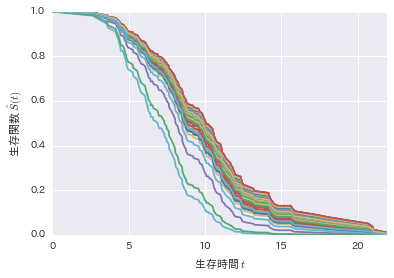

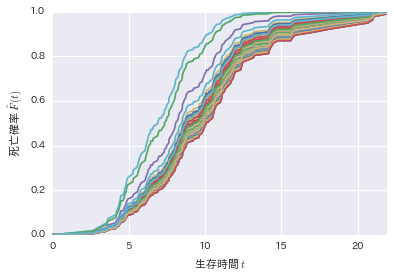

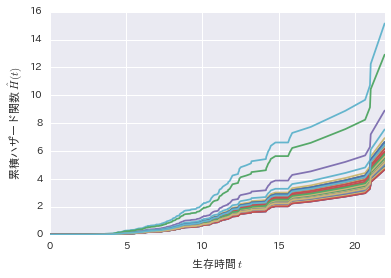

In [119]:
# 生存関数の描写
pred_survival_rate = cox_ph_model.predict_survival_function(test_df)
pred_survival_rate.plot(legend=False)
plt.ylabel("生存関数 $\hat{S}(t)$")
plt.xlabel("生存時間 $t$")
plt.show()

# ある時間tまでに死亡する確率の描写: F(t) = 1 - S(t)
pred_dead_rate = 1 - pred_survival_rate
pred_dead_rate.plot(legend=False)
plt.ylabel("死亡確率 $\hat{F}(t)$")
plt.xlabel("生存時間 $t$")
plt.show()

# 累積ハザード関数の描写
pred_cum_hazard_rate = cox_ph_model.predict_cumulative_hazard(test_df)
pred_cum_hazard_rate.plot(legend=False)
plt.ylabel("累積ハザード関数 $\hat{H}(t)$")
plt.xlabel("生存時間 $t$")
plt.show()

---
## 回帰モデルの検定
回帰モデルを当てはめたあとは、回帰係数の有意性を評価し、重要なパラメータ推定値の信頼区間を構築するが、そのためのいくつかの方法を示す。

> **<font color="blue">(対数)部分尤度比検定統計量</font>**
>
> $$
G = 2\left\{ \log {L_{p}\left(\hat {\beta}\right)} - \log {L_{p}\left(0\right)} \right\} \qquad (27)
$$
>
> ここで、$\beta = 0$のときの対数部分尤度は、
> $$
\log {L_{p}\left(0\right)} = - \sum _{i=1}^{m}{\log {\left( n_{i} \right)}}　\qquad (28)
$$
> - $n_{i}$: 観測された生存時間$t_{i}$におけるリスク集合にいる人数
> - 回帰係数が0に等しいという帰無仮説のもとで、部分尤度比検定統計量Gは**<font color="red">自由度1のカイ二乗分布</font>**に従う
> - 部分尤度比検定統計量の結果は、回帰係数の有意性を検定する$p$値の計算に利用される
> - 尤度比検定の前提となる斬近理論は、パラメータの数に対して、観測された生存時間の非打ち切り数が十分に大きいときに保証される
>
> $p$値:
> $$
Pr\left( \chi^{2}\left(1\right) \ge G \right)
$$

<br>

> **<font color="blue">Wald検定統計量</font>**(Wald stastistic): 
> この統計量は、推定された回帰係数$\hat {\beta}$とその標準誤差の比で構成される。
> $$
z = \frac {\hat {\beta}}{\hat {SE}\left( \hat {\beta} \right)} \qquad (29)
$$
> 
> - パラメータの数に対して、観測された生存時間の非打ち切り数が十分に大きいと仮定
> - Wald統計量は**<font color="red">標準正規分布</font>**に従う
> - Wald統計量を二乗したものは、帰無仮説のもとで**<font color="red">自由度1のカイ二乗分布</font>**に従う
>
> 両側$p$値:
>$$
Pr\left( \left| z \right| > z \right)
$$

<br>

> **<font color="blue">スコア検定統計量</font>**: この統計量は、対数部分尤度を微分した(22)式と、$\beta = 0$のもとで計算された観測情報量（(25)式）の平方根との比である。
> ![](./imgs/スコア統計量-30.png) (30)
>
> - パラメータの数に対して、観測された生存時間の非打ち切り数が十分に大きいと仮定
> - 回帰係数が0に等しいという帰無仮説のもとで、**<font color="red">標準正規分布</font>**に従う
> - スコア統計量を二乗したものは、帰無仮説のもとで**<font color="red">自由度1のカイ二乗分布</font>**に従う

実際に,3つの検定統計量は、通常かなり似ており、回帰係数の有意性検定については同様の結論を導く。しかし、結果に相違があった場合は、部分尤度比検定が最も好ましい検定である。

---
## パラメータの信頼区間推定
回帰係数の信頼区間は、Waldの信頼区間とも呼ばれる。それらの値は、回帰係数がその標準誤差をもつ正規分布に従うことに基づいている。

> **<font color="blue">回帰係数に対する$100(1-\alpha)$%信頼区間</font>**:
> $$
\hat {\beta} \pm z_{1-\alpha/2}\hat {SE}\left(\hat {\beta}\right)
$$

In [120]:
# モデルの有意性検定
## 今回、　1つの回帰係数に対して観測された生存時間の非打ち切り数が132なので、検定量の数学的仮定は満たされる
cox_ph_model.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
var1,0.220278,1.246423,0.087832,2.507944,0.012144,0.048092,0.392464


In [158]:
# 部分尤度比検定統計量

def calc_partial_likelihood_ratio_statistic(df, duration_col=None, event_col=None, log_likelihood=None):
    """
    部分尤度比検定統計量を算出
    """
    def calc_zero_log_likelihood(df, duration_col=None, event_col=None):
        """
        対数部分尤度に0を代入した値を算出
        log L(0)
        """
        sum_log = 0

        for time in train_df.sort_values(by=event_col)[event_col].values:
            risk_set = df[df[duration_col] >= time]
            n_risk_set = risk_set.shape[0]
            sum_log += np.log(n_risk_set)
        return - sum_log

    log_zero_likelihood = calc_zero_log_likelihood(train_df, duration_col, event_col)
    return 2*(log_likelihood - log_zero_likelihood)

log_likelihood = cox_ph_model._log_likelihood
G = calc_partial_likelihood_ratio_statistic(train_df, 'T', 'E', log_likelihood)
print("部分尤度比検定統計量: %s" % G)

66.6549613078


In [117]:
# Wald検定
from scipy.stats import norm #正規分布

alpha = 0.05 # 有意水準
z = cox_ph_model._compute_z_values()[0] #検定統計量(Wald検定統計量)

# 棄却域（両側検定）
a,b = norm.interval(1 - alpha)

if (z < a) or (b < z):
    print('帰無仮説は棄却される')
    print('モデルは有意である')
else:
    print('帰無仮説は棄却されない')
    print('モデルは有意ではない')

帰無仮説は棄却される
モデルは有意である


In [ ]:
# スコア検定


---
# 多変量モデル
以降では、共変量は、追跡開始時点でそれぞれの被験者に関して測定され、時間とともに値が変化しないことを前提とした$p$個の共変量を含む比例ハザードモデルに焦点を与える。

     
入力データ:
$$
(t_{i}, x_{i}, c_{i}) = (観測時間,共変量,打ち切り変数) \qquad (i=1,2,\cdots, n)
$$

 - $c_{i} =\begin{cases} 0\qquad 打ち切りじゃないデータ \\ 1\qquad 打ち切りデータ \end{cases}$
 - ベクトル$x_{i}^{\prime} = (x_{i1}, x_{i2}, \cdots, x_{ip})$: 被験者$i$に対する$p$個の共変量
     - 共変量ベクトルは、連続値・名義尺度の指示変数・共変量間の積(交互作用)などの共変量の集まりを含めることができる

> 部分尤度関数: (19)式の1つの共変量$x$をベクトル$x$に置き換えることによって得られる。
> $$
L_{ p }\left( \beta  \right) =\prod _{ i=1 }^{ n }{ { \left[ \frac { e^{ x_{ j }\beta  } }{ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { e }^{ { x }_{ j }\beta  } }  }  \right]  }^{ { c }_{ i } } } 
$$

> 対数部分尤度: タイデータが存在しないとする。よって、(20)式にベクトル$x$を代入して対数をとると以下になる。
> $$
\log { L_{ p }\left( \beta  \right)  } =\sum _{ i=1 }^{ m }{ \left\{ x_{ (i) }\beta -\log { \left[ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { e }^{ { x }_{ (j) }\beta  } }  \right]  }  \right\}  } 
$$
> →最大部分尤度推定量$\hat {\beta}^{\prime} = (\hat {\beta}_{1}, \hat {\beta}_{2}, \cdots, \hat {\beta}_{p})$は、上式からNewton-Raphson法により得ることができる

$k$番目の共変量で偏微分した対数部分尤度は
$$
\frac { \partial \log { L_{ p }\left( \beta  \right)  }  }{ \partial {\beta}_{k}  } =\sum _{ i=1 }^{ m }{ \left\{ x_{ (ik) }-\frac { \sum _{ j\in R\left( t_{ (i) } \right)  }{ x_{ jk }e^{ { x }_{ j }^{ \prime  }\beta  } }  }{ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { e }^{ { x }_{ j }^{ \prime  }\beta  } }  }  \right\}  } \\ \qquad \qquad \qquad =\sum _{ i=1 }^{ m }{ \left\{ x_{ (ik) }-\sum _{ j\in R\left( t_{ (i) } \right)  }{ { w }_{ ij }(\beta )x_{ jk } }  \right\}  } \qquad \left( { w }_{ ij }\left( \beta  \right) =\frac { { e }^{ { x }_{ j }^{ \prime  }\beta  } }{ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { e }^{ { x }_{ j }^{ \prime  }\beta  } }  }  \right) \\ \qquad \qquad \qquad =\sum _{ i=1 }^{ m }{ \left\{ x_{ (ik) }-{ \overline { x }  }_{ { w }_{ i }k } \right\}  } \qquad \left( { \overline { x }  }_{ { w }_{ i }k }=\sum _{ j\in R\left( t_{ (i) } \right)  }{ { w }_{ ij }(\beta )x_{ jk } }  \right) \qquad (31)
$$
である。

> **$p \times p$の情報行列**: (25)式の定義をすべての2次導関数を含むように多次元に拡張することで得られる。
> ![](./imgs/情報行列.png)
> この行列の要素の一般式は、(24)式から得られる。対角要素は
> $$
\frac { { \partial  }^{ 2 }\log { L_{ p }\left( \beta  \right)  }  }{ \partial { \beta _{ k } }^{ 2 } } = -\sum _{ i=1 }^{ m }{ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { w }_{ ij }{ \left( { x }_{ jk }-{ \overline { x }  }_{ { w }_{ i }k } \right)  }^{ 2 } }  } \qquad (32)
$$
> となり、非対角要素は、
> $$
\frac { { \partial  }^{ 2 }\log { L_{ p }\left( \beta  \right)  }  }{ \partial { \beta _{ k } }\partial { \beta _{ l } } } = -\sum _{ i=1 }^{ m }{ \sum _{ j\in R\left( t_{ (i) } \right)  }{ { w }_{ ij }\left( { x }_{ jk }-{ \overline { x }  }_{ { w }_{ i }k } \right) \left( { x }_{ jl }-{ \overline { x }  }_{ { w }_{ i }l } \right)  }  } \qquad (33)
$$
> となる。

<br>

> **回帰係数の共分散行列の推定量**: (26)式を拡張することで得られる。
> ![](./imgs/回帰係数の分散推定量-26.png)

<br>

> **標準誤差の推定量**:
> $$
\hat {SE}\left( \hat {\beta} \right) = \sqrt { \hat { Var } \left( \hat { \beta  }  \right)  } 
$$


## モデルの検定

> **<font color="blue">部分尤度比検定</font>**
> $$
G = 2 \left\{ \log {L_{p}\left( \hat {\beta} \right)} - \log {L_{p}\left(0\right)} \right\}\\
\log { L_{ p }\left( 0 \right)  } =- \sum _{ i=1 }^{ m }{ \log { \left( n_{ i } \right)  }  }
$$
>
> - $n_{i}$: 観測された生存時間$t_{i}$におけるリスク集合にいる人数
> - パラメータの数に対して、観測された生存時間の非打ち切り数が十分に大きい(大標本)を仮定
> - すべての回帰係数$\hat {\beta} = (\hat {\beta_{1}}, \hat {\beta_{2}}, \cdots, \hat {\beta_{p}})$が同時に0に等しいという帰無仮説のもとで、部分尤度比検定統計量Gは**<font color="red">自由度$p$(それぞれの回帰係数につき1つ)のカイ二乗分布</font>**に従う

<br>

> **<font color="blue">Wald検定</font>**:
> ![](./imgs/行列表記のWald統計量.png)
> - 漸近的に、**<font color="red">自由度$p$のカイ二乗分布</font>**に従う
> - モデル構築の過程で、個々の回帰係数に対するWald検定は、モデルの予測性を落とさずにモデルから不要な変数を取り除くために利用できる。

<br>

> **<font color="blue">スコア検定</font>**
> ![](./imgs/行列表記のスコア検定統計量.png)
>
> - 漸近的に、**<font color="red">自由度$p$のカイ二乗分布</font>**に従う